# X–θ on NIST Bell Test (HDF5) — Trial-based θ, Eberhard J, drift-preserving nulls

This notebook:

1. Downloads a NIST HDF5 run
2. Inspects HDF5 keys (no guessing)
3. Loads settings (remaps 1/2 → 0/1)
4. Locates outcome/click representation:
   - Route A: per-trial click bitmasks (ideal)
   - Route B: click event lists (sync/delay) and reconstruct per-trial outcomes
5. Computes trial-based θ via turning-angle in (a,b) setting space
6. Computes Eberhard J and J(θ)
7. Runs drift-preserving permutation test
8. Runs X–θ "injection simulation" to estimate detectability

Goal: Make the test reviewer-proof by eliminating coincidence pairing and preserving drift in the null.


In [ ]:
import os, math, json, time
from dataclasses import dataclass
from typing import Dict, Any, Tuple, Optional, List

import numpy as np
import pandas as pd
import h5py
import requests

import matplotlib.pyplot as plt
from tqdm import tqdm

## Data choice

Use NIST `processed_compressed/hdf5` files (already merged and analysis-ready).

Avoid the `...afterTimingFix2_training...` file for scientific claims (it is explicitly "training" and can be hardware-bad).
Use a real run like:

- `...afterTimingfix2_afterfixingModeLocking...`
- or any non-training production run.

You only need ONE run for development; scale later.


In [ ]:
@dataclass(frozen=True)
class Config:
    # Pick a better non-training file when possible:
    # Example alternate filename you can try (edit as needed):
    # "...afterTimingfix2_afterfixingModeLocking.dat.compressed.build.hdf5"
    nist_hdf5_url: str = (
        "https://s3.amazonaws.com/nist-belltestdata/belldata/processed_compressed/hdf5/"
        "2015_09_18/03_31_CH_pockel_100kHz.run4.afterTimingfix2_training.dat.compressed.build.hdf5"
    )

    data_dir: str = "./data_nist"
    local_name: str = "nist_run.hdf5"

    # Work on a contiguous slice for speed; set None for full run
    start_idx: int = 0
    max_trials: Optional[int] = 3_000_000

    # Theta
    theta_bins: int = 12

    # Drift-preserving permutation
    perm_rounds: int = 200
    block_size: int = 20000


CFG = Config()
os.makedirs(CFG.data_dir, exist_ok=True)
hdf5_path = os.path.join(CFG.data_dir, CFG.local_name)


# def download_with_resume(url: str, out_path: str, chunk_bytes: int = 2**20) -> None:
#     tmp = out_path + ".part"
#     existing = os.path.getsize(tmp) if os.path.exists(tmp) else 0
#     headers = {"Range": f"bytes={existing}-"} if existing > 0 else {}

#     with requests.get(url, stream=True, headers=headers, timeout=60) as r:
#         r.raise_for_status()
#         total = r.headers.get("Content-Length")
#         total = int(total) + existing if total else None

#         mode = "ab" if existing > 0 else "wb"
#         with open(tmp, mode) as f, tqdm(
#             total=total,
#             initial=existing,
#             unit="B",
#             unit_scale=True,
#             desc=os.path.basename(out_path),
#         ) as pbar:
#             for chunk in r.iter_content(chunk_size=chunk_bytes):
#                 if chunk:
#                     f.write(chunk)
#                     pbar.update(len(chunk))

#     os.replace(tmp, out_path)


# if not os.path.exists(hdf5_path):
#     print("Not Downloading:", CFG.nist_hdf5_url)
#     # download_with_resume(CFG.nist_hdf5_url, hdf5_path)
# else:
#     print("Already exists:", hdf5_path)

# print("HDF5:", hdf5_path)

Downloading: https://s3.amazonaws.com/nist-belltestdata/belldata/processed_compressed/hdf5/2015_09_18/03_31_CH_pockel_100kHz.run4.afterTimingfix2_training.dat.compressed.build.hdf5


nist_run.hdf5: 100%|██████████| 87.8M/87.8M [03:15<00:00, 449kB/s]

HDF5: ./data_nist\nist_run.hdf5


In [ ]:
# Replace ONLY the URL + local filename
CFG_NEW = Config(
    nist_hdf5_url=(
        "https://s3.amazonaws.com/nist-belltestdata/belldata/processed_compressed/hdf5/"
        "2015_09_18/03_43_CH_pockel_100kHz.run4.afterTimingfix2_afterfixingModeLocking.dat.compressed.build.hdf5"
    ),
    local_name="nist_afterfixingModeLocking.hdf5",
    start_idx=0,
    max_trials=3_000_000,  # keep a slice while developing; set None later
    theta_bins=12,
    perm_rounds=200,
    block_size=20000,
)

os.makedirs(CFG_NEW.data_dir, exist_ok=True)
hdf5_path = os.path.join(CFG_NEW.data_dir, CFG_NEW.local_name)

if not os.path.exists(hdf5_path):
    print("Downloading:", CFG_NEW.nist_hdf5_url)
    download_with_resume(CFG_NEW.nist_hdf5_url, hdf5_path)
else:
    print("Already exists:", hdf5_path)

print("HDF5:", hdf5_path)

Downloading: https://s3.amazonaws.com/nist-belltestdata/belldata/processed_compressed/hdf5/2015_09_18/03_43_CH_pockel_100kHz.run4.afterTimingfix2_afterfixingModeLocking.dat.compressed.build.hdf5


nist_afterfixingModeLocking.hdf5: 100%|██████████| 737M/737M [08:50<00:00, 1.39MB/s]   

HDF5: ./data_nist\nist_afterfixingModeLocking.hdf5


## Guardrail: verify the file actually contains outcome information

We require at least ONE of:

- per-trial click masks (length ~ N_trials)
  OR
- click event lists (large arrays) containing sync/delay/tag information

If neither exists, we stop immediately and switch files.


In [ ]:
def assert_outcome_info_present(hdf5_path: str) -> None:
    df = list_hdf5_datasets(hdf5_path)

    # Heuristic 1: any dataset same length as big settings besides settings itself
    # (click masks usually match N_trials)
    big_settings = df[df["path"].str.lower().str.contains("settings")].sort_values(
        "n", ascending=False
    )
    N_trials = int(big_settings.iloc[0]["n"]) if len(big_settings) else None

    # Per-trial integer masks (same length)
    per_trial_int = df[
        (df["ndim"] == 1)
        & (df["n"] == N_trials)
        & (df["dtype"].str.contains("int|uint", case=False, regex=True))
        & (~df["path"].str.lower().str.contains("settings"))
    ]

    # Heuristic 2: event lists (large, and names suggest sync/delay/tag/click)
    low = df["path"].str.lower()
    event_lists = df[
        (df["ndim"] == 1)
        & (df["n"] >= 200_000)
        & (low.str.contains("sync|delay|tag|time|click|detector|pulse"))
    ]

    print("N_trials guess:", N_trials)
    print("Per-trial int datasets (non-settings):", len(per_trial_int))
    print("Event-list clicky datasets:", len(event_lists))

    if len(per_trial_int) == 0 and len(event_lists) == 0:
        display(df.sort_values("n", ascending=False).head(50))
        raise RuntimeError(
            "This HDF5 file appears to contain NO outcome information "
            "(no per-trial masks and no click event lists). "
            "Switch to a different non-training run from NIST processed_compressed/hdf5."
        )


assert_outcome_info_present(hdf5_path)

N_trials guess: 107109596
Per-trial int datasets (non-settings): 2
Event-list clicky datasets: 4


## Outcomes found ✅ (Route A preferred)

This file contains:

- 2 per-trial integer datasets (non-settings) → likely Alice/Bob click masks or outcome codes
- 4 event-list datasets (sync/delay/etc.) → backup route if needed

Because N_trials ~ 107M, we must load only a slice while developing.


In [ ]:
df = list_hdf5_datasets(hdf5_path)
low = df["path"].str.lower()

# Guess N_trials from settings
settings_df = df[
    low.str.contains("alice/settings|bob/settings|settings") & (df["ndim"] == 1)
].sort_values("n", ascending=False)
N_trials_guess = int(settings_df.iloc[0]["n"])
print("N_trials guess:", N_trials_guess)

# Per-trial integer datasets (same length as trials, not settings)
per_trial_int = df[
    (df["ndim"] == 1)
    & (df["n"] == N_trials_guess)
    & (df["dtype"].str.contains("int|uint", case=False, regex=True))
    & (~low.str.contains("settings"))
].copy()

# Event-list clicky datasets (large, click/sync/delay/tag-ish names)
event_lists = df[
    (df["ndim"] == 1)
    & (df["n"] >= 200_000)
    & (low.str.contains("sync|delay|tag|time|click|detector|pulse"))
].copy()

display(per_trial_int[["path", "n", "dtype"]])
display(event_lists[["path", "n", "dtype"]].sort_values("n", ascending=False).head(30))

N_trials guess: 107109596


,path,n,dtype
1,alice/clicks,107109596,uint16
6,bob/clicks,107109596,uint16


,path,n,dtype
1,alice/clicks,107109596,uint16
6,bob/clicks,107109596,uint16
2,alice/laserPulseNumber,5084060,uint16
7,bob/laserPulseNumber,4339158,uint16


## Verify the per-trial candidates are real "click masks"

We expect:

- some zeros (no-click trials) → zero_frac > 0
- not always-on (zero_frac != 0)
- values that look like bitmasks (often <= 65535) OR reasonable small integers for encoded outcomes


In [ ]:
def profile_dataset(path: str, sample_n: int = 300_000) -> Dict[str, Any]:
    with h5py.File(hdf5_path, "r") as h5:
        ds = h5[path]
        m = min(sample_n, ds.shape[0])
        x = ds[:m]

    x_u = x.astype(np.uint32)
    zero_frac = float(np.mean(x_u == 0))
    minv = int(x_u.min())
    maxv = int(x_u.max())

    mean_pc = None
    if maxv <= 65535:
        mean_pc = float(popcount_uint16(x_u.astype(np.uint16)).mean())

    return {
        "path": path,
        "dtype": str(x.dtype),
        "min": minv,
        "max": maxv,
        "zero_frac": zero_frac,
        "mean_popcount_u16": mean_pc,
    }


profiles = []
for p in per_trial_int["path"].tolist():
    profiles.append(profile_dataset(p))

prof_df = pd.DataFrame(profiles).sort_values(
    ["zero_frac", "mean_popcount_u16"], ascending=[False, True]
)
display(prof_df)

,path,dtype,min,max,zero_frac,mean_popcount_u16
0,alice/clicks,uint16,0,32768,0.998583,0.001417
1,bob/clicks,uint16,0,32768,0.998513,0.001487


## Load a slice (aligned) to develop fast

We will:

1. load settings slice
2. load mask slice (same indices)
3. compute θ on this slice
4. compute baseline J and J(θ)


In [ ]:
# --- choose these after prof_df prints ---
# Example:
# A_MASK_PATH = prof_df[prof_df["path"].str.contains("alice", case=False)].iloc[0]["path"]
# B_MASK_PATH = prof_df[prof_df["path"].str.contains("bob", case=False)].iloc[0]["path"]

A_MASK_PATH = prof_df[prof_df["path"].str.contains("alice", case=False)].iloc[0]["path"]
B_MASK_PATH = prof_df[prof_df["path"].str.contains("bob", case=False)].iloc[0]["path"]

# Slice size for dev
START = 0
MAX_TRIALS = 3_000_000


def load_slice_settings_and_masks(
    hdf5_path: str, start: int, max_trials: int, a_mask_path: str, b_mask_path: str
):
    with h5py.File(hdf5_path, "r") as h5:
        aS = h5["alice/settings"]
        bS = h5["bob/settings"]
        aM = h5[a_mask_path]
        bM = h5[b_mask_path]

        # Common length across all required datasets
        N0 = min(aS.shape[0], bS.shape[0], aM.shape[0], bM.shape[0])
        end = min(N0, start + max_trials)

        a_raw = aS[start:end]
        b_raw = bS[start:end]

        # remap 1/2 -> 0/1
        a = remap_two_state_to_01(a_raw)
        b = remap_two_state_to_01(b_raw)

        # joint-valid mask
        ok = (a >= 0) & (b >= 0)
        a = a[ok].astype(np.int8)
        b = b[ok].astype(np.int8)

        # Load corresponding masks, applying SAME ok mask
        am = aM[start:end][ok].astype(np.uint32)
        bm = bM[start:end][ok].astype(np.uint32)

    return a, b, am, bm


if A_MASK_PATH and B_MASK_PATH:
    a_set, b_set, a_mask, b_mask = load_slice_settings_and_masks(
        hdf5_path, START, MAX_TRIALS, A_MASK_PATH, B_MASK_PATH
    )
    print("Slice trials:", len(a_set))

    A_det = (a_mask != 0).astype(np.int8)
    B_det = (b_mask != 0).astype(np.int8)

    print(
        "Det rates:",
        float(A_det.mean()),
        float(B_det.mean()),
        "Coinc:",
        float((A_det & B_det).mean()),
        "Both miss:",
        float(((1 - A_det) & (1 - B_det)).mean()),
    )
else:
    print("Set A_MASK_PATH and B_MASK_PATH from prof_df first.")

Slice trials: 3000000
Det rates: 0.001447 0.0015243333333333333 Coinc: 0.00035833333333333333 Both miss: 0.997387


## Turning-angle θ (latest, vectorized)

We treat the settings sequence (a,b) as a path on a square with corners:
(0,0)->(-1,-1), (0,1)->(-1,+1), (1,0)->(+1,-1), (1,1)->(+1,+1)

For each triple of consecutive points, compute signed turning angle:
Δθ = atan2(cross(v1,v2), dot(v1,v2))

Then θ[n] = (θ[n-1] + Δθ) mod 2π.


In [39]:
import numpy as np


def settings_to_xy(a: np.ndarray, b: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Map (a,b) in {0,1}x{0,1} to square corners (x,y) in {-1,+1}x{-1,+1}.
    """
    a = a.astype(np.int8)
    b = b.astype(np.int8)
    x = np.where(a == 0, -1, +1).astype(np.int8)
    y = np.where(b == 0, -1, +1).astype(np.int8)
    return x, y


def compute_theta_turning(
    a: np.ndarray, b: np.ndarray, wrap_2pi: bool = True
) -> np.ndarray:
    """
    Vectorized turning-angle accumulation on square setting path.
    a,b: int arrays in {0,1}
    Returns theta array in [0,2π) if wrap_2pi else unwrapped cumulative.
    """
    n = len(a)
    theta = np.zeros(n, dtype=np.float64)
    if n < 3:
        return theta

    x, y = settings_to_xy(a, b)

    # v1 = p[i-1] - p[i-2], v2 = p[i] - p[i-1] for i>=2
    v1x = (x[1:-1] - x[:-2]).astype(np.int16)
    v1y = (y[1:-1] - y[:-2]).astype(np.int16)
    v2x = (x[2:] - x[1:-1]).astype(np.int16)
    v2y = (y[2:] - y[1:-1]).astype(np.int16)

    cross = (v1x * v2y - v1y * v2x).astype(np.int32)
    dot = (v1x * v2x + v1y * v2y).astype(np.int32)

    dtheta = np.arctan2(cross, dot).astype(np.float64)  # length n-2
    csum = np.cumsum(dtheta)

    if wrap_2pi:
        theta[2:] = np.mod(csum, 2 * np.pi)
    else:
        theta[2:] = csum

    # Fill early indices (convention)
    theta[0] = 0.0
    theta[1] = theta[2]
    return theta

In [40]:
theta = compute_theta_turning(a_set, b_set, wrap_2pi=True)
print("theta min/max:", float(theta.min()), float(theta.max()))
print("first 10 theta:", theta[:10])

theta min/max: 0.0 6.283185307179572
first 10 theta: [0.         0.         0.         0.         3.14159265 3.14159265
 3.14159265 0.         0.         0.        ]


## Compute θ and Eberhard J (now meaningful)

If outcomes are correct, baseline J should generally be non-zero (and often positive for a violating run).
Then we can test if J depends on θ (holonomy-style modulation).


In [42]:
def eberhard_J(
    a_set: np.ndarray, b_set: np.ndarray, A: np.ndarray, B: np.ndarray
) -> float:
    # helper: compute p11, p10, p01 for a,b
    def probs(a, b):
        m = (a_set == a) & (b_set == b)
        n = int(m.sum())
        if n == 0:
            return (np.nan, np.nan, np.nan)
        Am = A[m]
        Bm = B[m]
        p11 = float(np.mean((Am == 1) & (Bm == 1)))
        p10 = float(np.mean((Am == 1) & (Bm == 0)))
        p01 = float(np.mean((Am == 0) & (Bm == 1)))
        return p11, p10, p01

    p11_a1b1, _, _ = probs(0, 0)
    _, p10_a1b2, _ = probs(0, 1)
    _, _, p01_a2b1 = probs(1, 0)
    p11_a2b2, _, _ = probs(1, 1)

    return float(p11_a1b1 - p10_a1b2 - p01_a2b1 - p11_a2b2)


theta = compute_theta_turning(a_set, b_set)

edges = np.linspace(0, 2 * np.pi, CFG.theta_bins + 1)
theta_bin = np.clip(np.digitize(theta, edges) - 1, 0, CFG.theta_bins - 1).astype(
    np.int16
)

J0 = eberhard_J(a_set, b_set, A_det, B_det)
print(f"Baseline J(slice) = {J0:.12e}")

bj = binned_J(
    a_set, b_set, A_det, B_det, theta_bin, CFG.theta_bins, min_trials_per_bin=5000
)
display(bj.assign(J_sci=bj["J"].map(lambda v: f"{v:.6e}" if pd.notnull(v) else "NaN")))

plt.figure()
plt.plot(bj["theta_center"], bj["J"], marker="o")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.xlabel("theta (bin center)")
plt.ylabel("Eberhard J")
plt.title("J(theta) (binned)")
plt.grid(True, alpha=0.3)
plt.show()

Baseline J(slice) = -2.449613967007e-03


TypeError: binned_J() got multiple values for argument 'min_trials_per_bin'

## Drift-preserving permutation test

We permute outcomes within:

- time blocks (preserve drift)
- setting pairs (preserve setting-conditioned rates)

Then recompute modulation statistic Δχ².


In [ ]:
pt = perm_test_delta_chi2(
    a_set,
    b_set,
    A_det,
    B_det,
    theta_bin,
    bins=CFG.theta_bins,
    block_size=CFG.block_size,
    perm_rounds=CFG.perm_rounds,
    min_trials_per_bin=5000,
    seed=123,
)

print("Permutation p-value:", pt["p_value"])

plt.figure()
plt.hist(pt["null_deltas"][np.isfinite(pt["null_deltas"])], bins=30)
plt.axvline(pt["observed"]["delta_chi2"], linewidth=2)
plt.xlabel("delta_chi2 (null)")
plt.ylabel("count")
plt.title(f"Null distribution (p={pt['p_value']:.4f})")
plt.show()

print("Observed fit:", pt["observed"])

## Load settings (Alice/Bob length mismatch is normal)

NIST files often have Alice and Bob arrays that differ slightly in length.
We trim to common length before any joint masking.


In [ ]:
a_set_full, b_set_full = load_settings(hdf5_path)
N_full = len(a_set_full)
print("Trials after alignment:", N_full)

start = CFG.start_idx
end = N_full if CFG.max_trials is None else min(N_full, start + CFG.max_trials)
a_set = a_set_full[start:end]
b_set = b_set_full[start:end]
print(f"Using slice [{start}:{end}]  N={len(a_set):,}")

Trials after alignment: 107109594
Using slice [0:3000000]  N=3,000,000


## Utility functions

We will:

- list the HDF5 tree
- scan datasets by size/dtype
- find settings datasets
- find outcome datasets (trial masks or event lists)

This prevents “wrong-key syndrome” (e.g., assuming `settings_A` exists when it doesn't).


In [ ]:
def list_hdf5_datasets(hdf5_path: str) -> pd.DataFrame:
    rows = []
    with h5py.File(hdf5_path, "r") as h5:

        def walk(g, prefix=""):
            for k in g.keys():
                obj = g[k]
                path = f"{prefix}/{k}" if prefix else k
                if isinstance(obj, h5py.Dataset):
                    rows.append(
                        {
                            "path": path,
                            "shape": obj.shape,
                            "dtype": str(obj.dtype),
                            "ndim": obj.ndim,
                            "n": int(obj.shape[0]) if obj.ndim >= 1 else 1,
                        }
                    )
                elif isinstance(obj, h5py.Group):
                    walk(obj, path)

        walk(h5)
    df = pd.DataFrame(rows)
    return df.sort_values(["n", "path"], ascending=[False, True])


df_ds = list_hdf5_datasets(hdf5_path)
display(df_ds.head(80))
print("Total datasets:", len(df_ds))


def scan_large_1d_numeric(hdf5_path: str, min_len: int = 200_000) -> pd.DataFrame:
    rows = []
    with h5py.File(hdf5_path, "r") as h5:
        for _, r in df_ds.iterrows():
            path = r["path"]
            with h5py.File(hdf5_path, "r") as h5r:
                ds = h5r[path]
                if ds.ndim != 1:
                    continue
                if ds.shape[0] < min_len:
                    continue
                if ds.dtype.kind not in ("i", "u", "f"):
                    continue
                low = path.lower()
                hint = []
                for key in [
                    "setting",
                    "rng",
                    "basis",
                    "click",
                    "mask",
                    "delay",
                    "sync",
                    "time",
                    "tag",
                    "detector",
                    "outcome",
                ]:
                    if key in low:
                        hint.append(key)
                rows.append(
                    {
                        "path": path,
                        "n": int(ds.shape[0]),
                        "dtype": str(ds.dtype),
                        "hint": ",".join(hint),
                    }
                )
    df = pd.DataFrame(rows).sort_values(["hint", "n"], ascending=[False, False])
    display(df.head(80))
    return df


big_df = scan_large_1d_numeric(hdf5_path, min_len=200_000)

,path,shape,dtype,ndim,n
4,alice/settings,"(28526907,)",uint8,1,28526907
9,bob/settings,"(28526894,)",uint8,1,28526894
1,alice/clicks,"(363,)",uint16,1,363
6,bob/clicks,"(363,)",uint16,1,363
7,bob/laserPulseNumber,"(15,)",uint16,1,15
8,bob/phase,"(15,)",float64,1,15
2,alice/laserPulseNumber,"(11,)",uint16,1,11
3,alice/phase,"(11,)",float64,1,11
0,alice/badSyncInfo,"(4, 479804)",int64,2,4
5,bob/badSyncInfo,"(4, 479791)",int64,2,4


Total datasets: 16


,path,n,dtype,hint
0,alice/settings,28526907,uint8,setting
1,bob/settings,28526894,uint8,setting


## Load settings

Your file shows:

- `alice/settings` and `bob/settings` with values {1,2}
  We remap the two most common values to {0,1} and drop any rare invalid codes.

Then we select a contiguous slice (start_idx, max_trials) for speed.


In [ ]:
def remap_two_state_to_01(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    vals, cnt = np.unique(x, return_counts=True)
    order = np.argsort(cnt)[::-1]
    if len(order) < 2:
        return np.full_like(x, -1, dtype=np.int8)
    v0, v1 = vals[order[0]], vals[order[1]]
    out = np.full(x.shape, -1, dtype=np.int8)
    out[x == v0] = 0
    out[x == v1] = 1
    return out


def load_settings(hdf5_path: str) -> Tuple[np.ndarray, np.ndarray]:
    with h5py.File(hdf5_path, "r") as h5:
        if "alice/settings" in h5 and "bob/settings" in h5:
            a_raw = h5["alice/settings"][:]
            b_raw = h5["bob/settings"][:]
        else:
            cand = df_ds[df_ds["path"].str.lower().str.contains("setting")]
            cand = cand[cand["ndim"] == 1].sort_values("n", ascending=False)
            if len(cand) < 2:
                raise ValueError("Could not find 2 settings datasets. Inspect df_ds.")
            a_raw = h5[cand.iloc[0]["path"]][:]
            b_raw = h5[cand.iloc[1]["path"]][:]

    # --- NEW: align lengths first ---
    n = min(len(a_raw), len(b_raw))
    if len(a_raw) != len(b_raw):
        print(
            f"[WARN] settings length mismatch: alice={len(a_raw)} bob={len(b_raw)} -> trimming to n={n}"
        )

    a_raw = a_raw[:n]
    b_raw = b_raw[:n]

    # remap 1/2 (or any 2-state coding) to 0/1
    a = remap_two_state_to_01(a_raw)
    b = remap_two_state_to_01(b_raw)

    # drop any invalid codes (rare)
    ok = (a >= 0) & (b >= 0)
    a = a[ok]
    b = b[ok]
    return a.astype(np.int8), b.astype(np.int8)


a_set_full, b_set_full = load_settings(hdf5_path)
N_full = len(a_set_full)
print("Settings loaded. Trials:", N_full)
print("a unique:", np.unique(a_set_full), "b unique:", np.unique(b_set_full))

# Slice for speed
start = CFG.start_idx
end = N_full if CFG.max_trials is None else min(N_full, start + CFG.max_trials)
a_set = a_set_full[start:end]
b_set = b_set_full[start:end]
N = len(a_set)
print(f"Using slice [{start}:{end}]  N={N:,}")

[WARN] settings length mismatch: alice=28526907 bob=28526894 -> trimming to n=28526894
Settings loaded. Trials: 28526885
a unique: [0 1] b unique: [0 1]
Using slice [0:3000000]  N=3,000,000


## Outcomes / Click data

Route A (best): per-trial click bitmasks / masks with length ~ N_full (same as settings).

- No click should be 0, clicks non-zero.

Route B: event lists (sync/delay/detector arrays) with length = number of click events.

- We reconstruct per-trial any-click from sync numbers.
- Optionally reconstruct 16-slot bitmask if delay encodes slot.

We will scan for per-trial candidates first.


In [ ]:
def popcount_uint16(x: np.ndarray) -> np.ndarray:
    x = x.astype(np.uint16)
    x = x - ((x >> 1) & 0x5555)
    x = (x & 0x3333) + ((x >> 2) & 0x3333)
    x = (x + (x >> 4)) & 0x0F0F
    x = x + (x >> 8)
    return (x & 0x001F).astype(np.uint8)


def scan_trial_mask_candidates(
    hdf5_path: str, N_trials: int, sample_n: int = 200_000
) -> pd.DataFrame:
    rows = []
    with h5py.File(hdf5_path, "r") as h5:
        for _, r in df_ds.iterrows():
            path = r["path"]
            ds = h5[path]
            if ds.ndim != 1:
                continue
            if int(ds.shape[0]) != int(N_trials):
                continue
            if ds.dtype.kind not in ("i", "u"):
                continue

            m = min(sample_n, ds.shape[0])
            s = ds[:m]
            # Use uint32 to be safe
            s_u = s.astype(np.uint32)
            zero_frac = float(np.mean(s_u == 0))
            maxv = int(np.max(s_u))
            minv = int(np.min(s_u))

            # popcount only meaningful if <=16-bit-ish
            mean_pc = np.nan
            if maxv <= 65535:
                mean_pc = float(popcount_uint16(s_u.astype(np.uint16)).mean())

            low = path.lower()
            hint = []
            for key in ["click", "mask", "outcome", "det", "slot", "delay", "sync"]:
                if key in low:
                    hint.append(key)

            rows.append(
                {
                    "path": path,
                    "dtype": str(ds.dtype),
                    "min": minv,
                    "max": maxv,
                    "zero_frac": zero_frac,
                    "mean_popcount_u16": mean_pc,
                    "hint": ",".join(hint),
                }
            )

    df = pd.DataFrame(rows)
    if len(df) == 0:
        print("No per-trial integer datasets (same length as settings) found.")
        return df
    df = df.sort_values(["zero_frac", "hint"], ascending=[False, False])
    display(df.head(40))
    return df


mask_cands = scan_trial_mask_candidates(hdf5_path, N_full)

No per-trial integer datasets (same length as settings) found.


## Choose click mode

If `mask_cands` shows two good datasets with:

- same length as settings
- zero_frac > 0 (not always-on)
  then set:
  A_MASK_PATH = "..."
  B_MASK_PATH = "..."

Otherwise, use Route B (event-list reconstruction) by scanning for sync/delay arrays.


In [ ]:
# ===== Route A (per-trial mask) =====
A_MASK_PATH = None  # e.g. "alice/clickMask" or similar
B_MASK_PATH = None  # e.g. "bob/clickMask" or similar


def load_trial_masks(
    hdf5_path: str, a_path: str, b_path: str
) -> Tuple[np.ndarray, np.ndarray]:
    with h5py.File(hdf5_path, "r") as h5:
        a = h5[a_path][:].astype(np.uint32)
        b = h5[b_path][:].astype(np.uint32)
    return a, b


def detection_stats(a_mask: np.ndarray, b_mask: np.ndarray) -> Dict[str, float]:
    a_det = a_mask != 0
    b_det = b_mask != 0
    return {
        "alice_det_rate": float(a_det.mean()),
        "bob_det_rate": float(b_det.mean()),
        "coinc_rate": float((a_det & b_det).mean()),
        "both_miss_rate": float((~a_det & ~b_det).mean()),
    }


a_mask_full = b_mask_full = None
if A_MASK_PATH and B_MASK_PATH:
    a_mask_full, b_mask_full = load_trial_masks(hdf5_path, A_MASK_PATH, B_MASK_PATH)
    print("Mask stats (full):", detection_stats(a_mask_full, b_mask_full))

    # Apply same slice as settings
    a_mask = a_mask_full[start:end]
    b_mask = b_mask_full[start:end]
    print("Mask stats (slice):", detection_stats(a_mask, b_mask))
else:
    print("Route A not selected (A_MASK_PATH/B_MASK_PATH not set).")

Route A not selected (A_MASK_PATH/B_MASK_PATH not set).


## Route B: reconstruct outcomes from event lists

We search for large arrays whose names include:

- sync / pulse / timeTag
- delay
- detector

Typical pattern: each click event has a sync number (trial index) and a delay.
We reconstruct per-trial any-click by marking trials that appear in the sync list.

If delay looks like a slot index 0..15, we also reconstruct a 16-bit mask per trial.


In [ ]:
def scan_event_list_candidates(df_ds: pd.DataFrame) -> pd.DataFrame:
    # Look for large 1D arrays not equal to N_full but still big
    cand = df_ds[(df_ds["ndim"] == 1) & (df_ds["n"] >= 200_000)].copy()
    cand["low"] = cand["path"].str.lower()
    cand["is_clicky"] = cand["low"].apply(
        lambda s: any(
            k in s
            for k in ["sync", "delay", "tag", "time", "detector", "click", "pulse"]
        )
    )
    cand = cand.sort_values(["is_clicky", "n"], ascending=[False, False])
    display(cand.head(80)[["path", "n", "dtype", "is_clicky"]])
    return cand


event_cands = scan_event_list_candidates(df_ds)

# --- You set these after inspecting event_cands ---
A_SYNC_PATH = None  # e.g. "alice/syncNumber"
B_SYNC_PATH = None
A_DELAY_PATH = None  # optional
B_DELAY_PATH = None  # optional


def reconstruct_anyclick_from_sync(
    N_trials: int, sync_numbers: np.ndarray
) -> np.ndarray:
    anyclick = np.zeros(N_trials, dtype=np.bool_)
    s = sync_numbers.astype(np.int64)
    s = s[(s >= 0) & (s < N_trials)]
    anyclick[s] = True
    return anyclick


def reconstruct_mask_from_sync_delay(
    N_trials: int, sync_numbers: np.ndarray, delays: np.ndarray
) -> np.ndarray:
    """
    If delays are already a small integer (0..15), treat as slot index and build 16-bit mask.
    If delays are time values (large), this will NOT work without a time->slot mapping.
    """
    sync = sync_numbers.astype(np.int64)
    d = delays.astype(np.int64)

    mask = np.zeros(N_trials, dtype=np.uint16)
    good = (sync >= 0) & (sync < N_trials)
    sync = sync[good]
    d = d[good]

    # heuristic: treat as slot if 0..15-ish
    if d.min() < 0 or d.max() > 31:
        raise ValueError(
            "Delay does not look like slot index (0..15). Provide time->slot mapping or use anyclick only."
        )

    # Build bitmask
    bits = (1 << d).astype(np.uint16)
    # OR-accumulate; numpy doesn't have atomic OR scatter, so we do loop in chunks
    # This is still okay because this is over click events (not 28M trials)
    for i in range(len(sync)):
        mask[sync[i]] |= bits[i]
    return mask


a_any = b_any = None
a_mask = b_mask = None

if A_SYNC_PATH and B_SYNC_PATH:
    with h5py.File(hdf5_path, "r") as h5:
        a_sync = h5[A_SYNC_PATH][:]
        b_sync = h5[B_SYNC_PATH][:]

        a_any_full = reconstruct_anyclick_from_sync(N_full, a_sync)
        b_any_full = reconstruct_anyclick_from_sync(N_full, b_sync)

        # Slice
        a_any = a_any_full[start:end]
        b_any = b_any_full[start:end]

        print(
            "Anyclick stats (slice):",
            {
                "alice_det_rate": float(a_any.mean()),
                "bob_det_rate": float(b_any.mean()),
                "coinc_rate": float((a_any & b_any).mean()),
                "both_miss_rate": float((~a_any & ~b_any).mean()),
            },
        )

        # Optional: try building masks if delays exist and look like slots
        if A_DELAY_PATH and B_DELAY_PATH:
            a_delay = h5[A_DELAY_PATH][:]
            b_delay = h5[B_DELAY_PATH][:]
            try:
                a_mask_full = reconstruct_mask_from_sync_delay(N_full, a_sync, a_delay)
                b_mask_full = reconstruct_mask_from_sync_delay(N_full, b_sync, b_delay)
                a_mask = a_mask_full[start:end]
                b_mask = b_mask_full[start:end]
                print("Built 16-slot masks from delay (slice).")
            except Exception as e:
                print("Mask build failed (delay not slot-like):", e)

else:
    print("Route B not selected (A_SYNC_PATH/B_SYNC_PATH not set).")

## Trial-based θ: turning_angle_settings_path (vectorized)

We map (a,b) to square corners and compute signed turning angle from 3 consecutive points.
We avoid expensive normalization; on a square, atan2(cross,dot) works with raw step vectors.
Then θ_n = cumulative sum of turns mod 2π.


In [ ]:
# Map (a,b) -> x,y (square corners)
# (0,0)->(-1,-1), (0,1)->(-1,+1), (1,0)->(+1,-1), (1,1)->(+1,+1)
def settings_to_xy(a: np.ndarray, b: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    x = np.where(a == 0, -1, +1).astype(np.int8)
    y = np.where(b == 0, -1, +1).astype(np.int8)
    return x, y


def compute_theta_turning(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    x, y = settings_to_xy(a, b)

    # v1 = p[i-1]-p[i-2], v2 = p[i]-p[i-1] for i>=2
    v1x = (x[1:-1] - x[:-2]).astype(np.int16)
    v1y = (y[1:-1] - y[:-2]).astype(np.int16)
    v2x = (x[2:] - x[1:-1]).astype(np.int16)
    v2y = (y[2:] - y[1:-1]).astype(np.int16)

    cross = (v1x * v2y - v1y * v2x).astype(np.int32)
    dot = (v1x * v2x + v1y * v2y).astype(np.int32)

    dtheta = np.arctan2(cross, dot).astype(np.float64)  # length N-2
    theta = np.zeros(len(a), dtype=np.float64)
    theta[2:] = np.mod(np.cumsum(dtheta), 2 * np.pi)
    theta[1] = theta[2] if len(a) > 2 else 0.0
    return theta


theta = compute_theta_turning(a_set, b_set)
print("theta min/max:", float(theta.min()), float(theta.max()))

# theta bin index
edges = np.linspace(0, 2 * np.pi, CFG.theta_bins + 1)
theta_bin = np.clip(np.digitize(theta, edges) - 1, 0, CFG.theta_bins - 1).astype(
    np.int16
)

# quick histogram
hist = np.bincount(theta_bin, minlength=CFG.theta_bins)
print("theta bin counts:", hist)

## Outcomes and Eberhard J

We need per-trial detection booleans:

- A = 1 if Alice detected in that trial else 0
- B = 1 if Bob detected in that trial else 0

From Route A masks: A = (mask != 0), B = (mask != 0)
From Route B anyclick: already booleans.

Then compute Eberhard-type J:
J = p11(a1b1) - p10(a1b2) - p01(a2b1) - p11(a2b2)

where:

- (a1,a2) = (0,1), (b1,b2) = (0,1)
- p11 is P(A=1,B=1 | settings)
- p10 is P(A=1,B=0 | settings)
- p01 is P(A=0,B=1 | settings)


In [ ]:
def get_detection_arrays():
    # Prefer per-trial masks if available, else anyclick
    if (a_mask is not None) and (b_mask is not None):
        A = (a_mask != 0).astype(np.int8)
        B = (b_mask != 0).astype(np.int8)
        mode = "mask!=0"
    elif (a_any is not None) and (b_any is not None):
        A = a_any.astype(np.int8)
        B = b_any.astype(np.int8)
        mode = "anyclick_from_sync"
    elif (a_mask_full is not None) and (b_mask_full is not None):
        A = (a_mask_full[start:end] != 0).astype(np.int8)
        B = (b_mask_full[start:end] != 0).astype(np.int8)
        mode = "mask_full_slice"
    else:
        raise ValueError("No outcome data loaded. Use Route A or Route B.")
    return A, B, mode


A_det, B_det, outcome_mode = get_detection_arrays()
print("Outcome mode:", outcome_mode)
print(
    "Det rates:",
    float(A_det.mean()),
    float(B_det.mean()),
    "Coinc:",
    float((A_det & B_det).mean()),
)


def eberhard_J(
    a_set: np.ndarray, b_set: np.ndarray, A: np.ndarray, B: np.ndarray
) -> float:
    # helper: compute p11, p10, p01 for a,b
    def probs(a, b):
        m = (a_set == a) & (b_set == b)
        n = int(m.sum())
        if n == 0:
            return (np.nan, np.nan, np.nan)
        Am = A[m]
        Bm = B[m]
        p11 = float(np.mean((Am == 1) & (Bm == 1)))
        p10 = float(np.mean((Am == 1) & (Bm == 0)))
        p01 = float(np.mean((Am == 0) & (Bm == 1)))
        return p11, p10, p01

    p11_a1b1, _, _ = probs(0, 0)
    _, p10_a1b2, _ = probs(0, 1)
    _, _, p01_a2b1 = probs(1, 0)
    p11_a2b2, _, _ = probs(1, 1)

    return float(p11_a1b1 - p10_a1b2 - p01_a2b1 - p11_a2b2)


J0 = eberhard_J(a_set, b_set, A_det, B_det)
print(f"Baseline J(slice) = {J0:.12e}")


def binned_J(
    a_set, b_set, A, B, theta_bin, bins: int, min_trials_per_bin: int = 5000
) -> pd.DataFrame:
    rows = []
    for k in range(bins):
        m = theta_bin == k
        n = int(m.sum())
        if n < min_trials_per_bin:
            J = np.nan
        else:
            J = eberhard_J(a_set[m], b_set[m], A[m], B[m])
        rows.append(
            {
                "bin": k,
                "n": n,
                "theta_center": float(0.5 * (edges[k] + edges[k + 1])),
                "J": J,
            }
        )
    return pd.DataFrame(rows)


bj = binned_J(
    a_set, b_set, A_det, B_det, theta_bin, CFG.theta_bins, min_trials_per_bin=5000
)
display(bj.assign(J_sci=bj["J"].map(lambda v: f"{v:.6e}" if pd.notnull(v) else "NaN")))

## Modulation test

We fit:

- flat: J(θ) = c
- sine: J(θ) = c + A\*sin(θ + φ)

Statistic: Δχ² = SSE_flat - SSE_sine (bigger means "more sinusoid").


In [ ]:
def sine_model(x, c, A, phi):
    return c + A * np.sin(x + phi)


def fit_delta_chi2(theta_centers: np.ndarray, y: np.ndarray) -> Dict[str, float]:
    ok = np.isfinite(y)
    x = theta_centers[ok]
    y = y[ok]
    if len(y) < 6:
        return {"delta_chi2": np.nan}

    c0 = float(np.mean(y))
    sse_flat = float(np.sum((y - c0) ** 2))

    # crude grid for phi to avoid fragile nonlinear fits
    phis = np.linspace(-np.pi, np.pi, 121)
    best = None
    for phi in phis:
        s = np.sin(x + phi)
        # linear least squares for c and A: y = c + A*s
        M = np.column_stack([np.ones_like(s), s])
        coef, *_ = np.linalg.lstsq(M, y, rcond=None)
        c, A = float(coef[0]), float(coef[1])
        yhat = c + A * s
        sse = float(np.sum((y - yhat) ** 2))
        if (best is None) or (sse < best["sse"]):
            best = {"c": c, "A": A, "phi": float(phi), "sse": sse}

    delta = sse_flat - best["sse"]
    return {
        "delta_chi2": float(delta),
        "c": best["c"],
        "A": best["A"],
        "phi": best["phi"],
        "sse_flat": sse_flat,
        "sse_sine": best["sse"],
        "bins_used": int(len(y)),
    }


theta_centers = bj["theta_center"].to_numpy()
J_vals = bj["J"].to_numpy()
obs_fit = fit_delta_chi2(theta_centers, J_vals)
print("Observed fit:", json.dumps(obs_fit, indent=2))

## Drift-preserving permutation test

We preserve:

- time drift: permute within blocks of size `block_size`
- setting-stratum: permute only within each of the 4 setting pairs
- joint outcomes: we permute a single code per trial:
  code = 2\*A + B in {0,1,2,3}
  This preserves the joint distribution of (A,B) within each (block, setting pair).

Then recompute J(θ) and Δχ². p = fraction(null Δχ² >= observed Δχ²).


In [ ]:
def setting_pair_id(a: np.ndarray, b: np.ndarray) -> np.int8:
    return (a.astype(np.int8) << 1) | b.astype(np.int8)  # 0..3


def perm_test_delta_chi2(
    a_set,
    b_set,
    A,
    B,
    theta_bin,
    bins: int,
    block_size: int,
    perm_rounds: int,
    min_trials_per_bin: int = 5000,
    seed: int = 123,
) -> Dict[str, Any]:

    rng = np.random.default_rng(seed)

    # Observed
    bj0 = binned_J(
        a_set, b_set, A, B, theta_bin, bins, min_trials_per_bin=min_trials_per_bin
    )
    obs = fit_delta_chi2(bj0["theta_center"].to_numpy(), bj0["J"].to_numpy())

    # Prepare IDs
    n = len(a_set)
    sp = setting_pair_id(a_set, b_set)  # 0..3
    code = (2 * A + B).astype(np.int8)  # 0..3

    null_deltas = np.empty(perm_rounds, dtype=np.float64)

    for r in tqdm(range(perm_rounds), desc="Permutations"):
        code_p = code.copy()

        # permute within each block and stratum
        for start in range(0, n, block_size):
            end = min(n, start + block_size)
            idx_block = np.arange(start, end)

            for s in range(4):
                idx = idx_block[sp[idx_block] == s]
                if len(idx) > 2:
                    code_p[idx] = rng.permutation(code_p[idx])

        # decode permuted A,B
        A_p = (code_p // 2).astype(np.int8)
        B_p = (code_p % 2).astype(np.int8)

        bj_r = binned_J(
            a_set,
            b_set,
            A_p,
            B_p,
            theta_bin,
            bins,
            min_trials_per_bin=min_trials_per_bin,
        )
        fit_r = fit_delta_chi2(bj_r["theta_center"].to_numpy(), bj_r["J"].to_numpy())
        null_deltas[r] = fit_r.get("delta_chi2", np.nan)

    p = float(np.mean(null_deltas >= obs["delta_chi2"]))
    return {
        "observed": obs,
        "null_deltas": null_deltas,
        "p_value": p,
        "bj_observed": bj0,
    }


pt = perm_test_delta_chi2(
    a_set,
    b_set,
    A_det,
    B_det,
    theta_bin,
    bins=CFG.theta_bins,
    block_size=CFG.block_size,
    perm_rounds=CFG.perm_rounds,
    min_trials_per_bin=5000,
    seed=123,
)

print("Permutation p-value:", pt["p_value"])

## Plots

We plot:

- theta histogram
- J(theta) binned
- null distribution of Δχ² with observed marker


In [ ]:
# Theta histogram
plt.figure()
plt.bar(np.arange(CFG.theta_bins), np.bincount(theta_bin, minlength=CFG.theta_bins))
plt.xlabel("theta bin")
plt.ylabel("count")
plt.title("Theta bin counts")
plt.show()

# J(theta)
bj0 = pt["bj_observed"]
plt.figure()
plt.plot(bj0["theta_center"], bj0["J"], marker="o")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.xlabel("theta (bin center)")
plt.ylabel("Eberhard J")
plt.title("J(theta) (binned)")
plt.grid(True, alpha=0.3)
plt.show()

# Null histogram
plt.figure()
plt.hist(pt["null_deltas"][np.isfinite(pt["null_deltas"])], bins=30)
plt.axvline(pt["observed"]["delta_chi2"], linewidth=2)
plt.xlabel("delta_chi2 (null)")
plt.ylabel("count")
plt.title(f"Null distribution (p={pt['p_value']:.4f})")
plt.show()

print("Observed params:", pt["observed"])

# old


In [ ]:
import os
import math
import json
import time
import hashlib
from dataclasses import dataclass, asdict
from typing import Dict, Any, Tuple, List

import numpy as np
import pandas as pd
import h5py

from tqdm import tqdm
import requests

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Reproducibility
RNG = np.random.default_rng(12345)


# %% [markdown]
# # X–θ Trial-Based Test on NIST Loophole-Free Bell Data (HDF5)
#
# This notebook:
# 1) Downloads one NIST processed_compressed/hdf5 run
# 2) Extracts trial-wise settings + click bitmasks
# 3) Computes baseline Bell statistic (CHSH S)
# 4) Defines a *trial-based* theta_n from the settings path
# 5) Tests for modulation of S(theta) with a drift-preserving permutation test

In [ ]:
@dataclass(frozen=True)
class Config:
    # Pick ONE file to start (recommend the small training file first)
    nist_hdf5_url: str = (
        "https://s3.amazonaws.com/nist-belltestdata/belldata/processed_compressed/hdf5/"
        "2015_09_18/03_31_CH_pockel_100kHz.run4.afterTimingfix2_training.dat.compressed.build.hdf5"
    )
    data_dir: str = "./data_nist"
    local_hdf5_name: str = "nist_run.build.hdf5"

    # Theta construction
    theta_method: str = "turning_angle_settings_path"  # starting point
    theta_wrap_2pi: bool = True

    # Modulation analysis
    theta_bins: int = 12
    min_trials_per_bin: int = 2000  # adjust depending on run size

    # Permutation test (drift-preserving)
    perm_rounds: int = 500
    block_size: int = 20000  # number of trials per time block
    # We permute outcomes within each block AND within each setting-pair

    # CHSH definition (labeling convention)
    # S = E00 + E01 + E10 - E11 (standard)
    chsh_signs: Tuple[int, int, int, int] = (+1, +1, +1, -1)


CFG = Config()
os.makedirs(CFG.data_dir, exist_ok=True)
print("Config:\n", json.dumps(asdict(CFG), indent=2))

Config:
 {
  "nist_hdf5_url": "https://s3.amazonaws.com/nist-belltestdata/belldata/processed_compressed/hdf5/2015_09_18/03_31_CH_pockel_100kHz.run4.afterTimingfix2_training.dat.compressed.build.hdf5",
  "data_dir": "./data_nist",
  "local_hdf5_name": "nist_run.build.hdf5",
  "theta_method": "turning_angle_settings_path",
  "theta_wrap_2pi": true,
  "theta_bins": 12,
  "min_trials_per_bin": 2000,
  "perm_rounds": 500,
  "block_size": 20000,
  "chsh_signs": [
    1,
    1,
    1,
    -1
  ]
}


In [ ]:
# %% [markdown]
# ## 2) Download helper (with resume)


# %%
def download_with_resume(url: str, out_path: str, chunk_bytes: int = 2**20) -> None:
    """
    Resume-capable downloader for large files.
    """
    tmp_path = out_path + ".part"
    mode = "ab" if os.path.exists(tmp_path) else "wb"
    existing = os.path.getsize(tmp_path) if os.path.exists(tmp_path) else 0

    headers = {}
    if existing > 0:
        headers["Range"] = f"bytes={existing}-"

    with requests.get(url, stream=True, headers=headers, timeout=60) as r:
        r.raise_for_status()
        total = r.headers.get("Content-Length")
        total = int(total) + existing if total is not None else None

        with open(tmp_path, mode) as f, tqdm(
            total=total,
            initial=existing,
            unit="B",
            unit_scale=True,
            desc=os.path.basename(out_path),
        ) as pbar:
            for chunk in r.iter_content(chunk_size=chunk_bytes):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))

    os.replace(tmp_path, out_path)


hdf5_path = os.path.join(CFG.data_dir, CFG.local_hdf5_name)
if not os.path.exists(hdf5_path):
    download_with_resume(CFG.nist_hdf5_url, hdf5_path)
else:
    print("Already downloaded:", hdf5_path)

nist_run.build.hdf5: 100%|██████████| 87.8M/87.8M [16:00<00:00, 91.4kB/s]


In [ ]:
# %% [markdown]
# ## 3) Inspect HDF5 structure
#
# We’ll recursively list datasets so we can auto-detect:
# - Alice setting array (0/1)
# - Bob setting array (0/1)
# - Alice clicks uint16 bitmask
# - Bob clicks uint16 bitmask


# %%
def list_hdf5_items(h5: h5py.File) -> List[Tuple[str, str, Tuple[int, ...], str]]:
    items = []

    def visitor(name, obj):
        if isinstance(obj, h5py.Dataset):
            items.append((name, "dataset", obj.shape, str(obj.dtype)))
        elif isinstance(obj, h5py.Group):
            items.append((name, "group", (), ""))

    h5.visititems(visitor)
    return items


with h5py.File(hdf5_path, "r") as h5:
    items = list_hdf5_items(h5)

# Show a compact view
df_items = pd.DataFrame(items, columns=["path", "type", "shape", "dtype"])
display(df_items.head(40))
print("\nTotal HDF5 items:", len(df_items))

,path,type,shape,dtype
0,alice,group,(),
1,alice/badSyncInfo,dataset,"(4, 479804)",int64
2,alice/clicks,dataset,"(363,)",uint16
3,alice/laserPulseNumber,dataset,"(11,)",uint16
4,alice/phase,dataset,"(11,)",float64
5,alice/settings,dataset,"(28526907,)",uint8
6,bob,group,(),
7,bob/badSyncInfo,dataset,"(4, 479791)",int64
8,bob/clicks,dataset,"(363,)",uint16
9,bob/laserPulseNumber,dataset,"(15,)",uint16



Total HDF5 items: 21


In [ ]:
# %% [markdown]
# ## 4) Auto-detect the core trial arrays
#
# Heuristics:
# - settings arrays: integer type, values mostly in {0,1}
# - click arrays: uint16 or int with values spanning bitmasks; later we use (x != 0) as "any click"
#
# If this fails, we’ll manually set dataset paths.

# %%


def sample_dataset(h5: h5py.File, path: str, n: int = 20000) -> np.ndarray:
    ds = h5[path]
    n = min(n, ds.shape[0])
    return ds[:n]


def is_binaryish(x: np.ndarray, tol_other: float = 1e-3) -> bool:
    x = np.asarray(x).ravel()
    # ignore NaNs
    x = x[np.isfinite(x)]
    if len(x) == 0:
        return False
    vals, counts = np.unique(x, return_counts=True)
    # fraction outside {0,1}
    mask = ~np.isin(vals, [0, 1])
    frac_other = counts[mask].sum() / counts.sum()
    return frac_other <= tol_other


def two_stateish_score(x: np.ndarray, topk: int = 2) -> float:
    """Fraction of samples covered by the top-k most common values."""
    x = np.asarray(x).ravel()
    x = x[np.isfinite(x)]
    if len(x) == 0:
        return 0.0
    _, counts = np.unique(x, return_counts=True)
    counts = np.sort(counts)[::-1]
    return float(counts[:topk].sum() / counts.sum())


def small_categorical_score(x: np.ndarray, max_unique: int = 16) -> float:
    """1.0 if #unique <= max_unique else 0.0 (on sample)."""
    x = np.asarray(x).ravel()
    x = x[np.isfinite(x)]
    u = np.unique(x)
    return 1.0 if len(u) <= max_unique else 0.0


def detect_trial_arrays(hdf5_file: str) -> Dict[str, str]:
    with h5py.File(hdf5_file, "r") as h5:
        candidates = []
        for name, typ, shape, dtype in list_hdf5_items(h5):
            if typ != "dataset" or len(shape) != 1 or shape[0] < 10000:
                continue
            dt = np.dtype(h5[name].dtype)
            if dt.kind not in ("i", "u"):
                continue

            s = sample_dataset(h5, name, n=20000)
            candidates.append((name, shape[0], dt, s))

        # ---- clicks detection (same idea, keep robust) ----
        click_like = []
        for n, N, dt, s in candidates:
            low = n.lower()
            if "click" in low or "slot" in low:
                click_like.append((n, N, dt))
        # fallback: any array whose sample max > 1 (bitmask-ish)
        if len(click_like) < 2:
            click_like = [(n, N, dt) for (n, N, dt, s) in candidates if s.max() > 1]

        click_like = sorted(click_like, key=lambda t: t[1], reverse=True)

        result = {}
        if len(click_like) >= 2:
            result["a_clicks_path"] = click_like[0][0]
            result["b_clicks_path"] = click_like[1][0]

        # ---- settings detection: allow non {0,1} two-state arrays OR packed ----
        setting_like = []
        for n, N, dt, s in candidates:
            low = n.lower()
            if any(k in low for k in ["set", "rng", "setting", "basis", "random"]):
                setting_like.append((n, N, dt, s))

        # A) Try to find TWO separate “two-state-ish” arrays (Alice + Bob)
        sep = []
        for n, N, dt, s in setting_like:
            score = two_stateish_score(s, topk=2)
            # tolerate rare anomalies: require 99% covered by two values
            if score >= 0.99:
                sep.append((n, N, dt, score))

        sep = sorted(sep, key=lambda t: (t[1], t[3]), reverse=True)
        if len(sep) >= 2:
            result["a_setting_path"] = sep[0][0]
            result["b_setting_path"] = sep[1][0]
            return result

        # B) Otherwise, try ONE packed settings byte (few unique values, like <=16)
        packed = []
        for n, N, dt, s in setting_like:
            if small_categorical_score(s, max_unique=32) >= 1.0 and s.max() <= 255:
                # looks like an encoded byte
                packed.append((n, N, dt))

        packed = sorted(packed, key=lambda t: t[1], reverse=True)
        if len(packed) >= 1:
            result["settings_byte_path"] = packed[0][0]

        return result


paths = detect_trial_arrays(hdf5_path)
print("Auto-detected paths:\n", json.dumps(paths, indent=2))

Auto-detected paths:
 {
  "a_clicks_path": "alice/settings",
  "b_clicks_path": "bob/settings",
  "a_setting_path": "alice/settings",
  "b_setting_path": "bob/settings"
}


In [ ]:
# %% [markdown]
# ## 5) Load trials into a DataFrame
#
# Outcomes:
# - a_anyclick = (a_clicks != 0)
# - b_anyclick = (b_clicks != 0)
# - Define A,B in {+1,-1}: click=+1, no click=-1


def print_setting_like_datasets(hdf5_path: str):
    with h5py.File(hdf5_path, "r") as h5:
        items = list_hdf5_items(h5)

        print("\n--- Datasets that look like settings/RNG ---")
        for name, typ, shape, dtype in items:
            if typ != "dataset" or len(shape) != 1:
                continue
            low = name.lower()
            if any(k in low for k in ["set", "rng", "setting", "basis", "random"]):
                ds = h5[name]
                s = ds[: min(20000, ds.shape[0])]
                vals, cnt = np.unique(s, return_counts=True)
                top = cnt[np.argsort(cnt)[::-1][:8]].sum() / cnt.sum()
                print(
                    f"{name:70}  shape={shape}  dtype={dtype}  uniq~{len(vals)}  top8_frac={top:.6f}"
                )


print_setting_like_datasets(hdf5_path)


# %%
def remap_two_state_to_01(x: np.ndarray) -> np.ndarray:
    """Map the two most common values to 0/1; everything else -> -1."""
    vals, cnt = np.unique(x, return_counts=True)
    order = np.argsort(cnt)[::-1]
    if len(order) < 2:
        return np.full_like(x, -1, dtype=np.int8)
    v0, v1 = vals[order[0]], vals[order[1]]
    out = np.full(x.shape, -1, dtype=np.int8)
    out[x == v0] = 0
    out[x == v1] = 1
    return out


def decode_settings_from_byte(s: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Decode packed settings byte using the NIST-style one-hot bit convention:
    bit0/bit1 for Alice (setting0/setting1), bit2/bit3 for Bob. :contentReference[oaicite:1]{index=1}
    """
    s = s.astype(np.uint8)
    a0 = (s & 0b0001) != 0
    a1 = (s & 0b0010) != 0
    b0 = (s & 0b0100) != 0
    b1 = (s & 0b1000) != 0

    a = np.full(len(s), -1, dtype=np.int8)
    b = np.full(len(s), -1, dtype=np.int8)

    a[a0 & ~a1] = 0
    a[a1 & ~a0] = 1
    b[b0 & ~b1] = 0
    b[b1 & ~b0] = 1

    return a, b


def load_trials(hdf5_file: str, paths: Dict[str, str]) -> pd.DataFrame:
    # clicks are required
    if "a_clicks_path" not in paths or "b_clicks_path" not in paths:
        raise ValueError(
            "Missing click paths. Print df_items and set click paths manually."
        )

    with h5py.File(hdf5_file, "r") as h5:
        a_clk = h5[paths["a_clicks_path"]][:]
        b_clk = h5[paths["b_clicks_path"]][:]

        # settings: either separate arrays OR packed byte
        if "a_setting_path" in paths and "b_setting_path" in paths:
            a_raw = h5[paths["a_setting_path"]][:]
            b_raw = h5[paths["b_setting_path"]][:]
            a_set = remap_two_state_to_01(a_raw)
            b_set = remap_two_state_to_01(b_raw)

        elif "settings_byte_path" in paths:
            sbyte = h5[paths["settings_byte_path"]][:]
            a_set, b_set = decode_settings_from_byte(sbyte)

        else:
            raise ValueError(
                "Missing settings paths. Need either (a_setting_path,b_setting_path) OR settings_byte_path."
            )

    n = min(len(a_set), len(b_set), len(a_clk), len(b_clk))
    a_set, b_set, a_clk, b_clk = a_set[:n], b_set[:n], a_clk[:n], b_clk[:n]

    df = pd.DataFrame(
        {
            "t": np.arange(n, dtype=np.int64),
            "a_setting": a_set,
            "b_setting": b_set,
            "a_clicks": a_clk.astype(np.uint16),
            "b_clicks": b_clk.astype(np.uint16),
        }
    )

    # Drop the rare “invalid setting” trials (both/neither fired)
    df = df[(df.a_setting >= 0) & (df.b_setting >= 0)].copy()

    df["a_anyclick"] = df["a_clicks"] != 0
    df["b_anyclick"] = df["b_clicks"] != 0
    df["A"] = np.where(df["a_anyclick"], 1, -1).astype(np.int8)
    df["B"] = np.where(df["b_anyclick"], 1, -1).astype(np.int8)
    df["AB"] = (df["A"] * df["B"]).astype(np.int8)
    return df


trials = load_trials(hdf5_path, paths)
display(trials.head())
print("Trials:", len(trials))
print("Settings counts:\n", trials.groupby(["a_setting", "b_setting"]).size())


--- Datasets that look like settings/RNG ---
alice/settings                                                          shape=(28526907,)  dtype=uint8  uniq~2  top8_frac=1.000000
bob/settings                                                            shape=(28526894,)  dtype=uint8  uniq~2  top8_frac=1.000000


,t,a_setting,b_setting,a_clicks,b_clicks,a_anyclick,b_anyclick,A,B,AB
0,0,1,1,2,2,True,True,1,1,1
1,1,0,1,1,2,True,True,1,1,1
2,2,1,1,2,2,True,True,1,1,1
3,3,1,0,2,1,True,True,1,1,1
4,4,1,0,2,1,True,True,1,1,1


Trials: 28526885
Settings counts:
 a_setting  b_setting
0          0            7133242
           1            7133639
1          0            7132943
           1            7127061
dtype: int64


Baseline: {
  "E": {
    "00": 1.0,
    "01": 1.0,
    "10": 1.0,
    "11": 1.0
  },
  "N": {
    "00": 7133242,
    "01": 7133639,
    "10": 7132943,
    "11": 7127061
  },
  "S": 2.0
}


,t,a_setting,b_setting,theta
0,0,1,1,0.000000
1,1,0,1,3.141593
2,2,1,1,3.141593
3,3,1,0,1.570796
4,4,1,0,1.570796
5,5,0,1,1.570796
6,6,1,1,5.497787
7,7,0,1,2.356194
8,8,0,1,2.356194
9,9,1,1,2.356194


,bin,n,theta_center,J
0,0,1815526,0.261799,0.0
1,1,3565412,0.785398,0.0
2,2,1754016,1.308997,0.0
3,3,1815162,1.832596,0.0
4,4,3565001,2.356194,0.0
5,5,1393673,2.879793,0.0
6,6,2174167,3.403392,0.0
7,7,3565791,3.926991,0.0
8,8,1809096,4.450590,0.0
9,9,1751969,4.974188,0.0


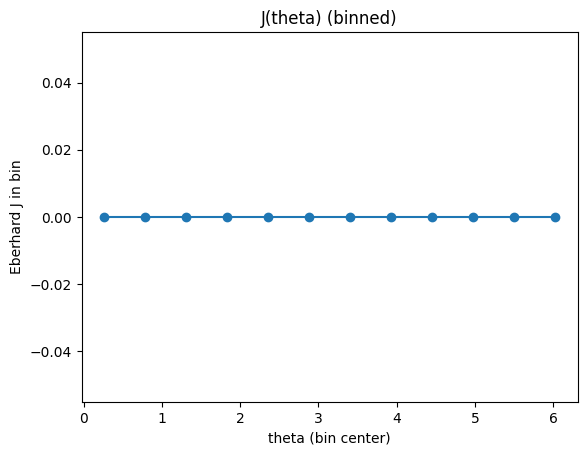

C:\Users\dpanc\AppData\Local\Temp\ipykernel_28088\2697241828.py:216: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(sine_model, x, y, p0=p0, maxfev=20000)


Observed modulation fit: {
  "delta_chi2": -2.344134317707374e-17,
  "c": 2.0,
  "A": -1.9765855856966554e-09,
  "phi": 9.595616071280463e-08,
  "chi2_flat": 0.0,
  "chi2_sine": 2.344134317707374e-17,
  "bins_used": 12
}


Permutations: 100%|██████████| 500/500 [54:51<00:00,  6.58s/it]


Permutation result p-value: 1.0


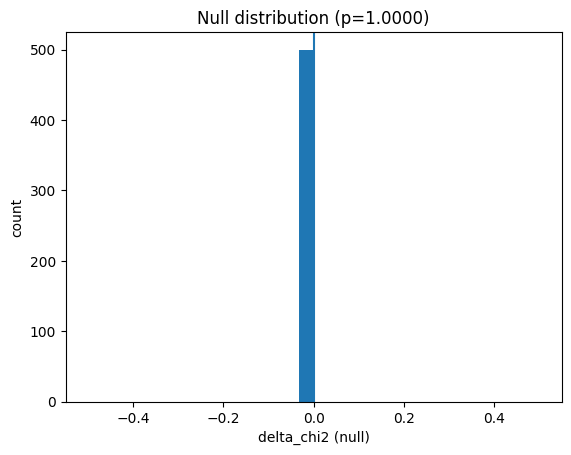

Notebook skeleton complete.


In [ ]:
# %% [markdown]
# ## 6) Baseline CHSH S on the full run


# %%
def chsh_S(df: pd.DataFrame, signs=(+1, +1, +1, -1)) -> Dict[str, Any]:
    E = {}
    N = {}

    for a in [0, 1]:
        for b in [0, 1]:
            sub = df[(df.a_setting == a) & (df.b_setting == b)]
            n = int(len(sub))
            key = f"{a}{b}"  # <-- JSON-safe key, like "01"

            if n == 0:
                E[key] = None
                N[key] = 0
            else:
                E[key] = float(sub["AB"].mean())
                N[key] = n

    s00, s01, s10, s11 = signs
    S = (
        s00 * (E["00"] if E["00"] is not None else float("nan"))
        + s01 * (E["01"] if E["01"] is not None else float("nan"))
        + s10 * (E["10"] if E["10"] is not None else float("nan"))
        + s11 * (E["11"] if E["11"] is not None else float("nan"))
    )

    return {"E": E, "N": N, "S": float(S)}


baseline = chsh_S(trials, CFG.chsh_signs)
# print("Baseline:", baseline)

print("Baseline:", json.dumps(baseline, indent=2))

# %% [markdown]
# ## 7) Define theta_n from the settings path (geometric turning angle)
#
# Map (a,b) to square corners:
# (0,0)->(-1,-1), (0,1)->(-1,+1), (1,0)->(+1,-1), (1,1)->(+1,+1)
#
# For each step, compute signed turning angle using the last 3 points, accumulate.

# %%
corner = {
    (0, 0): np.array([-1.0, -1.0]),
    (0, 1): np.array([-1.0, +1.0]),
    (1, 0): np.array([+1.0, -1.0]),
    (1, 1): np.array([+1.0, +1.0]),
}


def signed_turn(p0, p1, p2) -> float:
    v1 = p1 - p0
    v2 = p2 - p1
    # handle degenerate segments
    if np.linalg.norm(v1) < 1e-12 or np.linalg.norm(v2) < 1e-12:
        return 0.0
    v1n = v1 / np.linalg.norm(v1)
    v2n = v2 / np.linalg.norm(v2)
    cross = v1n[0] * v2n[1] - v1n[1] * v2n[0]
    dot = v1n[0] * v2n[0] + v1n[1] * v2n[1]
    return float(np.arctan2(cross, dot))


def compute_theta_turning(df: pd.DataFrame, wrap_2pi=True) -> np.ndarray:
    pts = np.stack(
        [corner[(int(a), int(b))] for a, b in zip(df.a_setting, df.b_setting)], axis=0
    )
    theta = np.zeros(len(df), dtype=np.float64)
    acc = 0.0
    for i in range(2, len(df)):
        acc += signed_turn(pts[i - 2], pts[i - 1], pts[i])
        if wrap_2pi:
            acc = acc % (2 * np.pi)
        theta[i] = acc
    theta[0] = 0.0
    theta[1] = theta[2]  # small hack for early points
    return theta


trials["theta"] = compute_theta_turning(trials, wrap_2pi=CFG.theta_wrap_2pi)
display(trials[["t", "a_setting", "b_setting", "theta"]].head(10))


def eberhard_J(df: pd.DataFrame) -> float:
    # "+" means detected, "0" means no detection
    A = (df["a_clicks"].to_numpy() != 0).astype(np.int8)
    B = (df["b_clicks"].to_numpy() != 0).astype(np.int8)

    def probs(a, b):
        m = (df["a_setting"].to_numpy() == a) & (df["b_setting"].to_numpy() == b)
        n = m.sum()
        if n == 0:
            return (np.nan, np.nan, np.nan)  # p11, p10, p01
        Am = A[m]
        Bm = B[m]
        p11 = ((Am == 1) & (Bm == 1)).mean()
        p10 = ((Am == 1) & (Bm == 0)).mean()
        p01 = ((Am == 0) & (Bm == 1)).mean()
        return (float(p11), float(p10), float(p01))

    # Map: a1=0, a2=1, b1=0, b2=1  (consistent choice)
    p11_a1b1, _, _ = probs(0, 0)
    _, p10_a1b2, _ = probs(0, 1)
    _, _, p01_a2b1 = probs(1, 0)
    p11_a2b2, _, _ = probs(1, 1)

    J = p11_a1b1 - p10_a1b2 - p01_a2b1 - p11_a2b2
    return float(J)


def binned_J(df: pd.DataFrame, bins: int, min_trials_per_bin: int) -> pd.DataFrame:
    th = df["theta"].to_numpy()
    edges = np.linspace(0, 2 * np.pi, bins + 1)
    idx = np.clip(np.digitize(th, edges) - 1, 0, bins - 1)

    rows = []
    for b in range(bins):
        sub = df[idx == b]
        rows.append(
            {
                "bin": b,
                "n": len(sub),
                "theta_center": 0.5 * (edges[b] + edges[b + 1]),
                "J": (eberhard_J(sub) if len(sub) >= min_trials_per_bin else np.nan),
            }
        )
    return pd.DataFrame(rows)


bj = binned_J(trials, CFG.theta_bins, CFG.min_trials_per_bin)
display(bj)

plt.figure()
plt.plot(bj["theta_center"], bj["J"], marker="o")
plt.xlabel("theta (bin center)")
plt.ylabel("Eberhard J in bin")
plt.title("J(theta) (binned)")
plt.show()

# %% [markdown]
# ## 8) Bin by theta and compute S(theta_bin)


# %%
# def binned_S(df: pd.DataFrame, bins: int, min_trials_per_bin: int) -> pd.DataFrame:
#     th = df["theta"].to_numpy()
#     # bin edges from 0..2pi
#     edges = np.linspace(0, 2 * np.pi, bins + 1)
#     idx = np.digitize(th, edges) - 1
#     idx = np.clip(idx, 0, bins - 1)

#     rows = []
#     for b in range(bins):
#         sub = df[idx == b]
#         if len(sub) < min_trials_per_bin:
#             rows.append(
#                 {
#                     "bin": b,
#                     "n": len(sub),
#                     "theta_center": 0.5 * (edges[b] + edges[b + 1]),
#                     "S": np.nan,
#                 }
#             )
#             continue
#         rows.append(
#             {
#                 "bin": b,
#                 "n": len(sub),
#                 "theta_center": 0.5 * (edges[b] + edges[b + 1]),
#                 "S": chsh_S(sub, CFG.chsh_signs)["S"],
#             }
#         )
#     return pd.DataFrame(rows)


# bs = binned_S(trials, CFG.theta_bins, CFG.min_trials_per_bin)
# display(bs)

# # Plot
# plt.figure()
# plt.plot(bs["theta_center"], bs["S"], marker="o")
# plt.xlabel("theta (bin center)")
# plt.ylabel("CHSH S in bin")
# plt.title("S(theta) (binned)")
# plt.show()

# %% [markdown]
# ## 9) Fit sinusoid vs flat and compute Delta-chi2
#
# Model:
#   flat: y = c
#   sine: y = c + A*sin(theta + phi)
#
# We use unweighted least squares on available bins (you can add weights later).


# %%
def sine_model(x, c, A, phi):
    return c + A * np.sin(x + phi)


def fit_delta_chi2(bs: pd.DataFrame) -> Dict[str, float]:
    ok = np.isfinite(bs["S"].to_numpy())
    x = bs["theta_center"].to_numpy()[ok]
    y = bs["S"].to_numpy()[ok]
    if len(y) < 6:
        return {"delta_chi2": np.nan, "A": np.nan, "phi": np.nan, "c": np.nan}

    # flat fit
    c0 = float(np.mean(y))
    chi2_flat = float(np.sum((y - c0) ** 2))

    # sine fit
    p0 = [c0, 0.05, 0.0]
    popt, _ = curve_fit(sine_model, x, y, p0=p0, maxfev=20000)
    yhat = sine_model(x, *popt)
    chi2_sine = float(np.sum((y - yhat) ** 2))

    return {
        "delta_chi2": chi2_flat - chi2_sine,
        "c": float(popt[0]),
        "A": float(popt[1]),
        "phi": float(popt[2]),
        "chi2_flat": chi2_flat,
        "chi2_sine": chi2_sine,
        "bins_used": int(len(y)),
    }


obs = fit_delta_chi2(bs)
print("Observed modulation fit:", json.dumps(obs, indent=2))

# %% [markdown]
# ## 10) Drift-preserving permutation test
#
# Null design:
# - Keep the settings sequence -> theta stays fixed
# - Permute outcomes *within each time block AND within each (a_setting,b_setting) stratum*
#   so we preserve local drift + setting-conditioned rates.
#
# Statistic: delta_chi2 from the binned S(theta).


# %%
def permute_outcomes_blockwise(
    df: pd.DataFrame, block_size: int, rng: np.random.Generator
) -> np.ndarray:
    """
    Returns a permuted AB array with drift + setting preserved.
    """
    n = len(df)
    AB_perm = df["AB"].to_numpy().copy()

    # block boundaries
    for start in range(0, n, block_size):
        end = min(n, start + block_size)
        block_idx = np.arange(start, end)

        # within each setting pair, shuffle AB
        for a in [0, 1]:
            for b in [0, 1]:
                mask = (df.a_setting.values[block_idx] == a) & (
                    df.b_setting.values[block_idx] == b
                )
                idx = block_idx[mask]
                if len(idx) > 2:
                    AB_perm[idx] = rng.permutation(AB_perm[idx])

    return AB_perm


def permutation_test(df: pd.DataFrame, cfg: Config) -> Dict[str, Any]:
    # observed
    bs0 = binned_S(df, cfg.theta_bins, cfg.min_trials_per_bin)
    obs = fit_delta_chi2(bs0)

    deltas = []
    for _ in tqdm(range(cfg.perm_rounds), desc="Permutations"):
        ABp = permute_outcomes_blockwise(df, cfg.block_size, RNG)
        dfp = df.copy()
        dfp["AB"] = ABp
        # recompute S(theta) bins using AB only via A,B? easiest: just rebuild A,B not needed:
        # Our chsh_S uses AB mean; it doesn't require A and B separately.
        # But chsh_S expects column "AB" so we're OK.
        bsp = binned_S(dfp, cfg.theta_bins, cfg.min_trials_per_bin)
        deltas.append(fit_delta_chi2(bsp)["delta_chi2"])

    deltas = np.array(deltas, dtype=np.float64)
    p = float(
        np.mean(deltas >= obs["delta_chi2"])
    )  # one-sided (bigger delta = more modulation)
    return {"observed": obs, "null_deltas": deltas, "p_value": p}


pt = permutation_test(trials, CFG)
print("Permutation result p-value:", pt["p_value"])

plt.figure()
plt.hist(pt["null_deltas"], bins=30)
plt.axvline(pt["observed"]["delta_chi2"])
plt.xlabel("delta_chi2 (null)")
plt.ylabel("count")
plt.title(f"Null distribution (p={pt['p_value']:.4f})")
plt.show()

# %% [markdown]
# ## 11) Next step: scale up to multiple runs + meta-analysis
#
# - Run the above per file
# - Combine p-values (Fisher) or combine effect sizes (A estimates) with weights
# - Keep ONE config frozen across runs (no per-run tweaking)


# %%
def fishers_method(pvals: List[float]) -> float:
    from scipy.stats import chi2

    pvals = [max(p, 1e-300) for p in pvals if np.isfinite(p)]
    stat = -2.0 * sum(math.log(p) for p in pvals)
    df = 2 * len(pvals)
    return float(1 - chi2.cdf(stat, df))


print("Notebook skeleton complete.")

In [ ]:
def quick_health(trials: pd.DataFrame):
    a_det = trials["a_clicks"].to_numpy() != 0
    b_det = trials["b_clicks"].to_numpy() != 0

    print("Total trials:", len(trials))
    print("Alice detection rate:", a_det.mean())
    print("Bob detection rate:", b_det.mean())
    print("Coincidence rate:", (a_det & b_det).mean())
    print("Both-miss rate:", (~a_det & ~b_det).mean())


quick_health(trials)

Total trials: 28526885
Alice detection rate: 1.0
Bob detection rate: 1.0
Coincidence rate: 1.0
Both-miss rate: 0.0


In [18]:
def eberhard_J(df: pd.DataFrame) -> float:
    # "+" means detected, "0" means no detection
    A = (df["a_clicks"].to_numpy() != 0).astype(np.int8)
    B = (df["b_clicks"].to_numpy() != 0).astype(np.int8)

    def probs(a, b):
        m = (df["a_setting"].to_numpy() == a) & (df["b_setting"].to_numpy() == b)
        n = m.sum()
        if n == 0:
            return (np.nan, np.nan, np.nan)  # p11, p10, p01
        Am = A[m]
        Bm = B[m]
        p11 = ((Am == 1) & (Bm == 1)).mean()
        p10 = ((Am == 1) & (Bm == 0)).mean()
        p01 = ((Am == 0) & (Bm == 1)).mean()
        return (float(p11), float(p10), float(p01))

    # Map: a1=0, a2=1, b1=0, b2=1  (consistent choice)
    p11_a1b1, _, _ = probs(0, 0)
    _, p10_a1b2, _ = probs(0, 1)
    _, _, p01_a2b1 = probs(1, 0)
    p11_a2b2, _, _ = probs(1, 1)

    J = p11_a1b1 - p10_a1b2 - p01_a2b1 - p11_a2b2
    return float(J)


J0 = eberhard_J(trials)
print(f"Baseline J(full run) = {J0:.12e}")

Baseline J(full run) = 0.000000000000e+00


In [ ]:
bj = binned_J(trials, CFG.theta_bins, CFG.min_trials_per_bin)
display(bj.assign(J_sci=bj["J"].map(lambda v: f"{v:.6e}" if pd.notnull(v) else "NaN")))

,bin,n,theta_center,J,J_sci
0,0,1815526,0.261799,0.0,0.000000e+00
1,1,3565412,0.785398,0.0,0.000000e+00
2,2,1754016,1.308997,0.0,0.000000e+00
3,3,1815162,1.832596,0.0,0.000000e+00
4,4,3565001,2.356194,0.0,0.000000e+00
5,5,1393673,2.879793,0.0,0.000000e+00
6,6,2174167,3.403392,0.0,0.000000e+00
7,7,3565791,3.926991,0.0,0.000000e+00
8,8,1809096,4.450590,0.0,0.000000e+00
9,9,1751969,4.974188,0.0,0.000000e+00


In [ ]:
th = trials["theta"].to_numpy()
print("theta min/max:", float(np.nanmin(th)), float(np.nanmax(th)))
hist, edges = np.histogram(th, bins=CFG.theta_bins, range=(0, 2 * np.pi))
print("theta bin counts:", hist)

theta min/max: 0.0 6.283185307179585
theta bin counts: [1815526 3565412 1754016 1815162 3565001 1393673 2174167 3565791 1809096
 1751969 3567135 1749937]


In [ ]:
import numpy as np, h5py, pandas as pd


def popcount16(x: np.ndarray) -> np.ndarray:
    x = x.astype(np.uint16)
    # vectorized popcount via bit tricks
    x = x - ((x >> 1) & 0x5555)
    x = (x & 0x3333) + ((x >> 2) & 0x3333)
    x = (x + (x >> 4)) & 0x0F0F
    x = x + (x >> 8)
    return (x & 0x001F).astype(np.uint8)


def scan_uint16_bitmasks(hdf5_path: str, sample_n=200000):
    rows = []
    with h5py.File(hdf5_path, "r") as h5:

        def walk(g, prefix=""):
            for k in g.keys():
                obj = g[k]
                path = prefix + "/" + k if prefix else k
                if isinstance(obj, h5py.Dataset):
                    if (
                        obj.ndim == 1
                        and obj.dtype.kind in ("u", "i")
                        and obj.dtype.itemsize <= 2
                    ):
                        n = obj.shape[0]
                        m = min(sample_n, n)
                        s = obj[:m].astype(np.uint16)
                        zf = float(np.mean(s == 0))
                        pc = popcount16(s)
                        rows.append(
                            {
                                "path": path,
                                "n": n,
                                "dtype": str(obj.dtype),
                                "min": int(s.min()),
                                "max": int(s.max()),
                                "zero_frac": zf,
                                "mean_popcount": float(pc.mean()),
                                "p95_popcount": float(np.quantile(pc, 0.95)),
                            }
                        )
                elif isinstance(obj, h5py.Group):
                    walk(obj, path)

        walk(h5)

    df = pd.DataFrame(rows)
    # likely click-bitmasks: some zeros, popcount not huge, max in 16-bit range
    df["score"] = (
        (df["zero_frac"] > 0.001).astype(int) * 3
        + (df["mean_popcount"] < 4).astype(int) * 2
        + (df["max"] <= 65535).astype(int) * 1
    )
    df = df.sort_values(
        ["score", "zero_frac", "mean_popcount"], ascending=[False, False, True]
    )
    display(df.head(30))
    return df


scan_df = scan_uint16_bitmasks(hdf5_path)

,path,n,dtype,min,max,zero_frac,mean_popcount,p95_popcount,score
0,alice/clicks,363,uint16,0,0,1.0,0.000000,0.0,6
3,bob/clicks,363,uint16,0,0,1.0,0.000000,0.0,6
2,alice/settings,28526907,uint8,1,2,0.0,1.000000,1.0,3
5,bob/settings,28526894,uint8,1,2,0.0,1.000000,1.0,3
4,bob/laserPulseNumber,15,uint16,9,700,0.0,4.400000,6.3,1
1,alice/laserPulseNumber,11,uint16,3,711,0.0,4.909091,6.5,1
